In [144]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys, os, glob
from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.table import Column, Table, vstack, join, unique
from astroquery.vizier import Vizier
from astroquery.ipac.irsa import Irsa
Vizier.TIMEOUT = 3600
Vizier.clear_cache()
from importlib import reload
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from itertools import product
from astropy.units import equivalencies

# access utilities provided in cigale package
sys.path.append('../../SED/manual/code')
import convert_Fx
import xray_filter

In [4]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

# original code

In [2]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [3]:
import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

### Read DES AGN table and get the photometry

In [ ]:
import pandas as pd
df_phot_gal_all = pd.read_csv('des/df_phot_gal_all.csv')

In [ ]:
# Read final DES candidates
data_agn = ascii.read('des_agn_updated.txt')
cat_agn = SkyCoord(data_agn['RA'], data_agn['dec'], unit='deg')

# Match photometry to final DES candidates
coord_phot_gal = SkyCoord(df_phot_gal_all['RA'], df_phot_gal_all['DEC'], unit=u.deg)
idx_phot,idx_des,d2d,d3d = cat_agn.search_around_sky(coord_phot_gal, 1*u.arcsec)

df_phot_gal_all_var = df_phot_gal_all.iloc[idx_phot]
df_phot_gal_all_var

### CIGALE

In [361]:
cigale_dir = 'cigale'

central_wavelengths = np.array([0.354, 0.475, 0.622, 0.763, 0.905, 1.25, 1.65, 2.20])*u.um
band_keys = ['U', 'G', 'R', 'I', 'Z', 'J', 'H', 'KS']

# Save photometry data
fmt = ' '.join(['%d'] + ['%0.6f']*(len(band_keys)*2 + 1)) # 17
hdr = 'id redshift u_prime g_prime r_prime i_prime z_prime vista.vircam.J vista.vircam.H vista.vircam.Ks u_prime_err g_prime_err r_prime_err i_prime_err z_prime_err vista.vircam.J_err vista.vircam.H_err vista.vircam.Ks_err'
print(len(hdr.split()))

data_phot = np.full([len(df_phot_gal_all_var), len(hdr.split(' '))], -9999.)
for i,b in enumerate(band_keys):
    flux = (df_phot_gal_all_var['MAG_' + b].values*u.ABmag).to(u.mJy).value
    mag_err = (df_phot_gal_all_var['MAGERR_' + b]).values
    #mag_err = np.sqrt(mag_err**2 + rms**2)
    # dmag = 2.5 / ln(10) * dF / F
    # dF = F dmag ln(10) / 2.5
    flux_err = np.log(10)/2.5*flux*mag_err
    
    data_phot[:,2+i] = flux
    data_phot[:,len(band_keys)+2+i] = flux_err

# Index
data_phot[:,0] = np.arange(len(df_phot_gal_all_var))

# Add redshift
mask_specz = np.isfinite(data_agn[r'$z_{\rm{sp}}$'].data)
data_phot[mask_specz,1] = data_agn[r'$z_{\rm{sp}}$'][mask_specz]

z_ph = data_agn[r'$z_{\rm{ph}}$'].data
z_ph = np.array([d[1:4] for d in z_ph], dtype=float)
data_phot[~mask_specz,1] = z_ph[~mask_specz]

np.savetxt('des/cigale/float/phot.dat', data_phot, header=hdr, fmt=fmt)
np.savetxt('des/cigale/fagn0/phot.dat', data_phot, header=hdr, fmt=fmt)
np.savetxt('des/cigale/fagn1/phot.dat', data_phot, header=hdr, fmt=fmt)

18


In [362]:
table.Table(data_phot, names=hdr.split(' '))

id,redshift,u_prime,g_prime,r_prime,i_prime,z_prime,vista.vircam.J,vista.vircam.H,vista.vircam.Ks,u_prime_err,g_prime_err,r_prime_err,i_prime_err,z_prime_err,vista.vircam.J_err,vista.vircam.H_err,vista.vircam.Ks_err
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,1.0,0.003259392833689053,0.005355849305528978,0.009485941101669684,0.01696780209195836,0.02304188250055944,0.03745848042053805,0.04972650083722634,0.06963527779888559,8.536874355701907e-05,3.3975430648396554e-05,5.119057490594685e-05,8.854521412946378e-05,0.0001386066445437506,7.498868198266016e-05,0.00010325624704843901,0.00015643115034388318
1.0,0.2,0.0008034623749175177,0.0013166155749859707,0.002173930597212546,0.003153339361525384,0.005010806091343175,0.00599908408286837,0.009722005749254858,0.01931687680820154,7.254710818976549e-05,1.637347317721991e-05,2.1838771558864996e-05,3.5604513539019204e-05,6.471785975396711e-05,0.0001828123767514316,0.00025934273291877675,0.0002971974174255415
2.0,1.0,0.0013735499393547194,0.0016415889560509927,0.0015992580749092287,0.0024373291243802637,0.0021081955214840207,0.004676741550951573,0.006328821990407733,0.00792965673378994,4.8563449724989015e-05,1.6364115033971475e-05,2.2873763822497293e-05,3.708525631021651e-05,6.961694344607743e-05,4.357361292595105e-05,6.163356022300745e-05,8.007142353039103e-05
3.0,1.3,0.0030643827776379675,0.002151373587160526,0.002755592841046999,0.0026506235807830067,0.0032892094193264915,0.004412015823716417,0.006547080721671842,0.005536421596899963,5.151780922102878e-05,1.714718880179903e-05,2.3326532252469058e-05,3.5532892685995556e-05,6.170472697564273e-05,0.00013204150430538785,0.00022182305516675735,0.0003207749336436598
4.0,0.6,0.008511903167368691,0.00967236554135058,0.012325052780103922,0.012463938682754748,0.013994297767709107,0.00700322875384395,0.006410738382387595,0.008625747725899184,7.267252053802783e-05,2.0220162272586325e-05,2.7111241620652663e-05,4.232192744177975e-05,7.400395246668162e-05,0.00017026563420514067,0.000226827058713145,0.0002766813533326393
5.0,0.803,0.0008164933492307221,0.0011504784367894166,0.0016431083598161913,0.0030481442360198586,0.0034146230006585824,0.002464831720798562,0.0035848720720882306,0.0074207149543490366,5.353806155401492e-05,1.5452440232882362e-05,2.092514952161251e-05,3.719925478919871e-05,6.102366829836989e-05,9.677074166069276e-05,0.00011816955877905482,0.0002498116295609276
6.0,1.2,0.06497441236313248,0.07427176231191354,0.0766340403243844,0.07320712510726568,0.07561773570085539,0.1295867439500251,0.11339653341204758,0.17092878011475648,0.00028523090862848065,9.81054013174942e-05,0.00012506049168445438,0.00018755643780091988,0.00032127529061776194,0.0018015171970248624,0.001862178613142762,0.0023765781636129395
7.0,2.9784,0.00242266949335246,0.002666595312922367,0.0030045603511550147,0.0045941959922590715,0.0053333039377501815,0.012238783165759336,0.01629436392303686,0.019405407344421748,5.019769695604193e-05,1.664231763214068e-05,2.1954937194802382e-05,3.6207512626123646e-05,6.23148365174453e-05,0.00012612376818337855,0.00015756067711229335,0.0001917264926779077
8.0,1.4,0.016489297706210205,0.055377430777617975,0.14179500289323405,0.2016471108497657,0.256884914911397,0.15183676635000587,0.1649579095355921,0.16529756054259867,0.00012855616105070228,7.034631769273253e-05,0.00015665660971033674,0.0002294503345887584,0.00032183432731509013,0.001449287097826681,0.0017766141296831856,0.001834452531331437


conda activate cigale

cd cigale

pcigale run

### Updated stellar masses

In [313]:
hdul = fits.open('des/cigale/float/out/results.fits')
results_float = hdul[1].data

hdul = fits.open('des/cigale/fagn1/out/results.fits')
results_fagn1 = hdul[1].data

hdul = fits.open('des/cigale/fagn0/out/results.fits')
results_fagn0 = hdul[1].data

mask_fit = results_float['best.reduced_chi_square'] < 10
mask_chi2 = ((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) > 2) & mask_fit

Text(0.5, 0, 'dchi2')

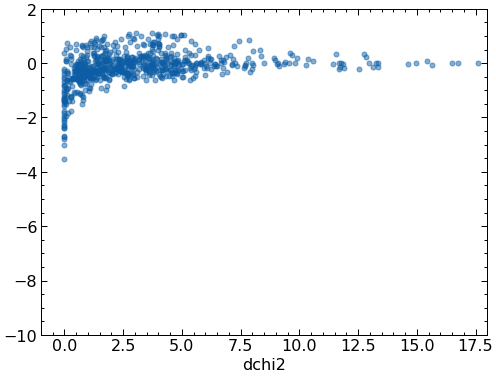

In [309]:
plt.errorbar((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']),
            np.log10(results_float['bayes.stellar.m_star'])-np.log10(results_fagn0['bayes.stellar.m_star']),
            ms=5, linestyle='none', marker='o', alpha=0.5)

# Show 0.3 dex

#plt.scatter(np.log10(results_float['best.stellar.m_star']),
#            np.log10(results_fagn0['best.stellar.m_star']))

plt.xlim(-1, 18)
plt.ylim(-10, 2)
plt.xlabel('dchi2')

Text(0, 0.5, '$M{_\\ast,f_{{\\rm{AGN}}=[0-1]}} - M{_\\ast,f_{{\\rm{AGN}}=0}}$')

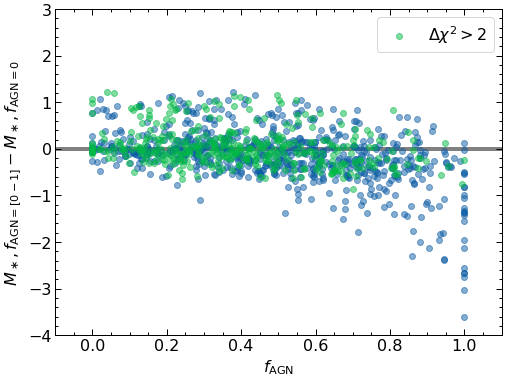

In [380]:
plt.scatter(np.clip(results_float['best.agn.fracAGN'] + np.random.normal(0,0.1,len(results_float)), 0, 1),
            np.log10(results_float['bayes.stellar.m_star']) - np.log10(results_fagn0['best.stellar.m_star']),
            alpha=0.5)


plt.scatter(np.clip((results_float['best.agn.fracAGN']+np.random.normal(0,0.1,len(results_float))), 0, 1)[mask_chi2],
            (np.log10(results_float['bayes.stellar.m_star']) - np.log10(results_fagn0['best.stellar.m_star']))[mask_chi2],
            alpha=0.5, label=r'$\Delta \chi^2 > 2$')

plt.plot([-0.1,1.1],[0,0], color='gray', lw=4, zorder=-1)

plt.xlim(-0.1, 1.1)
plt.ylim(-4, 3)

plt.legend(frameon=True)

plt.xlabel(r'$f_{\rm{AGN}}$')
plt.ylabel(r'$M{_\ast,f_{{\rm{AGN}}=[0-1]}} - M{_\ast,f_{{\rm{AGN}}=0}}$')

Text(0, 0.5, '$M{_\\ast,f_{{\\rm{AGN}}=[0-1]}}$')

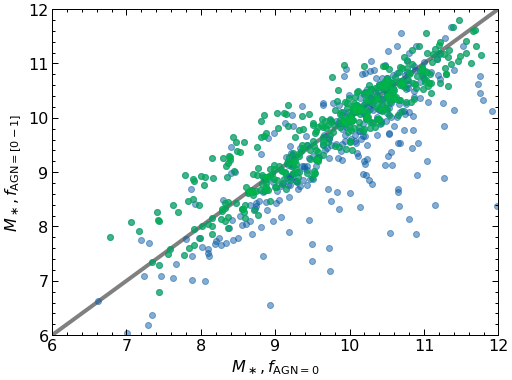

In [386]:
mask_chi2 = (results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) > 2


plt.scatter(np.log10(results_fagn0['best.stellar.m_star']),
            np.log10(results_float['bayes.stellar.m_star']),
            alpha=0.5)


plt.scatter(np.log10(results_fagn0['best.stellar.m_star'])[mask_chi2],
            np.log10(results_float['bayes.stellar.m_star'])[mask_chi2],
            alpha=0.5)

plt.plot([6,12],[6,12], color='gray', lw=4, zorder=-1)

plt.xlim(6, 12)
plt.ylim(6, 12)

plt.xlabel(r'$M{_\ast,f_{{\rm{AGN}}=0}}$')
plt.ylabel(r'$M{_\ast,f_{{\rm{AGN}}=[0-1]}}$')

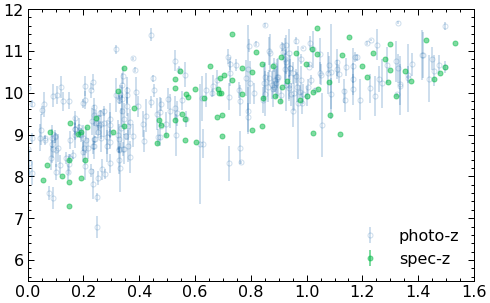

In [315]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))

dM = 0.434*results_float['bayes.stellar.m_star_err']/results_float['bayes.stellar.m_star']

ax.errorbar(z_ph[~mask_specz & mask_chi2]+np.random.normal(0, 0.1,len(z_ph[~mask_specz & mask_chi2])),# & mask_chi2],
             np.log10(results_float['bayes.stellar.m_star'][~mask_specz & mask_chi2]),# & mask_chi2]),
             yerr=dM[~mask_specz & mask_chi2],# & mask_chi2],
             marker='o', linestyle='none', mfc='none', ms=5, label='photo-z', alpha=0.2)

ax.errorbar(data_agn[r'$z_{\rm{sp}}$'][mask_specz & mask_chi2],
             np.log10(results_float['bayes.stellar.m_star'][mask_specz & mask_chi2]),
             yerr=0,
             marker='o', linestyle='none', ms=5, label='spec-z', alpha=0.5)

ax.set_ylim(5.5, 12)
ax.set_xlim(0, 1.6)

ax.legend()

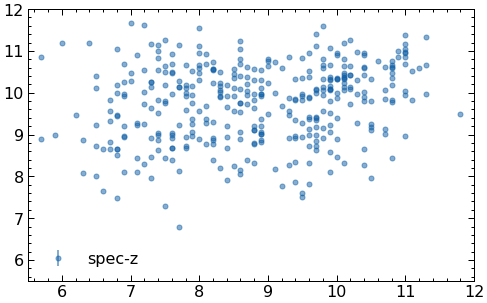

In [364]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))

M_star_Burke = np.array([d.split(' ')[0][1:] for d in data_agn[r'$\log\ \frac{M_{\ast}}{M_{\odot}}$']], dtype=float)

ax.errorbar(M_star_Burke[idx_des][mask_chi2],
            np.log10(results_float['bayes.stellar.m_star'][mask_chi2]),
            yerr=0,
            marker='o', linestyle='none', ms=5, label='spec-z', alpha=0.5)

ax.set_ylim(5.5, 12)
ax.set_xlim(5.5, 12)

ax.legend()

In [354]:
data_phot #['redshift']

array([[0.00000000e+00, 1.00000000e+00, 3.25939283e-03, ...,
        7.49886820e-05, 1.03256247e-04, 1.56431150e-04],
       [1.00000000e+00, 2.00000000e-01, 8.03462375e-04, ...,
        1.82812377e-04, 2.59342733e-04, 2.97197417e-04],
       [2.00000000e+00, 1.00000000e+00, 1.37354994e-03, ...,
        4.35736129e-05, 6.16335602e-05, 8.00714235e-05],
       ...,
       [7.03000000e+02, 1.44300000e-01, 7.27956046e-03, ...,
        3.89417713e-05, 6.14628268e-05, 8.54100856e-05],
       [7.04000000e+02, 6.94000000e-02, 2.66960065e-03, ...,
        3.77621419e-05, 5.20246822e-05, 8.14728593e-05],
       [7.05000000e+02, 1.90900000e-01, 8.09196986e-04, ...,
        6.14838608e-05, 7.47878068e-05, 1.05583508e-04]])

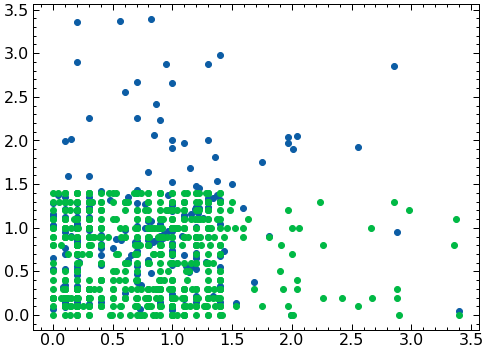

In [363]:
plt.scatter(data_phot[:,1], data_agn[idx_des][r'$z_{\rm{sp}}$'])
plt.scatter(data_phot[:,1], z_ph[idx_des])

In [316]:
len(data_agn[r'$z_{\rm{sp}}$'][mask_specz & mask_chi2])

104

In [336]:
mask_mass = np.log10(results_float['bayes.stellar.m_star']) < 9.5
data_agn[idx_des][mask_specz & mask_chi2 & mask_mass]

Name,RA,dec,$g$,SNR,$\sigma_{\rm{LB}}$,$\log\ \frac{M_{\ast}}{M_{\odot}}$,$\Delta\chi_\nu^2$,"$\log\ \frac{\tau_{\rm{\textsc{DRW},rest}}}{\rm{days}}$",$z_{\rm{ph}}$,$z_{\rm{sp}}$,$z_{\rm{sp}}$ source,$W1{-}W2$,$\log \frac{F_{2-7 {\rm{\ keV}}}}{{\rm{erg\ s}}^{-1} {\rm{\ cm}}^{-2}}$,Field
str20,float64,float64,float64,float64,float64,str14,float64,str16,str22,float64,str4,float64,float64,str5
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,$0.60^{+0.25}_{-0.05}$,nan,None,nan,nan,SN-C3
J033112.06-272056.04,52.8003,-27.3489,24.1,9.8,10.2,$8.9 \pm 0.4$,0.3,$2.3 \pm 0.8$,$1.49^{+nan}_{-0.03}$,nan,None,nan,nan,SN-C3
J033011.41-272133.13,52.5475,-27.3592,23.3,15.3,13.5,$7.4 \pm 0.6$,0.0,$1.7 \pm 0.3$,$0.25^{+0.01}_{-0.02}$,nan,None,nan,nan,SN-C3
J033009.72-282139.05,52.5405,-28.3608,22.7,19.7,17.1,$9.7 \pm 0.4$,0.1,$3.0 \pm 0.7$,$1.40^{+0.15}_{-0.25}$,nan,None,1.1,nan,SN-C3
J033136.60-280524.71,52.9025,-28.0902,23.3,10.5,4.3,$9.0 \pm 0.5$,0.1,$0.0 \pm 0.4$,$0.47^{+0.01}_{-0.02}$,nan,None,18.4,nan,SN-C3
J033322.86-280313.09,53.3453,-28.0536,23.1,21.2,17.5,$8.4 \pm 0.7$,0.1,$2.6 \pm 0.7$,$0.30^{+0.01}_{-0.02}$,nan,None,0.8,nan,SN-C3
J033314.30-282004.95,53.3096,-28.3347,22.2,8.9,10.7,$10.7 \pm 0.3$,0.3,$1.6 \pm 0.2$,$1.10^{+0.10}_{-0.05}$,nan,None,0.8,nan,SN-C3
J033318.95-281625.73,53.329,-28.2738,22.8,20.2,17.2,$8.2 \pm 0.4$,0.2,$2.9 \pm 0.8$,$0.22^{+0.01}_{-0.01}$,nan,None,nan,nan,SN-C3
J033013.29-284602.16,52.5554,-28.7673,23.5,12.8,10.3,$9.4 \pm 0.7$,0.2,$2.1 \pm 0.5$,$0.75^{+0.02}_{-0.02}$,nan,None,1.2,nan,SN-C3


# Updated Code

In [5]:
data_agn = ascii.read('des_agn_updated.txt')

cat_agn = SkyCoord(data_agn['RA'], data_agn['dec'], unit='deg')

data_agn[:5]

Name,RA,dec,g,SNR,sigma_LB,lgM,dchi2,lgtau,z_ph,z_ph_plus,z_ph_minus,z_sp,z_sp source,W1-W2,lgF,Field,z_simb,r_z_simb,z_ozdes,z_best
str20,float64,float64,float64,float64,float64,str14,float64,str16,float64,float64,str4,float64,str4,float64,float64,str5,float64,str19,float64,float64
J032833.79-271056.42,52.1408,-27.1823,23.7,14.2,13.3,$10.1 \pm 0.4$,0.1,$3.2 \pm 0.6$,1.02,0.03,0.04,nan,None,0.4,nan,SN-C3,-1.0,--,-1.0,-1.0
J032951.20-271057.43,52.4633,-27.1826,23.4,15.3,12.7,$7.8 \pm 0.7$,0.1,$1.9 \pm 0.3$,0.24,0.04,0.02,nan,None,18.6,nan,SN-C3,-1.0,--,-1.0,-1.0
J032944.64-271107.53,52.436,-27.1854,23.4,20.1,16.3,$9.4 \pm 0.5$,0.0,$2.4 \pm 0.8$,1.09,0.02,0.02,nan,None,0.9,nan,SN-C3,-1.0,--,-1.0,-1.0
J032845.45-271117.18,52.1894,-27.1881,21.5,22.8,18.3,$9.7 \pm 0.0$,5.0,$1.7 \pm 0.2$,1.3,0.1,0.15,nan,None,1.1,nan,SN-C3,-1.0,--,-1.0,-1.0
J032843.19-271117.75,52.1799,-27.1883,23.8,13.4,12.4,$8.8 \pm 0.5$,0.0,$2.7 \pm 0.8$,0.6,0.25,0.05,nan,None,nan,nan,SN-C3,-1.0,--,-1.0,-1.0


## query or fetch all data

Chandra query

readme: https://cdsarc.cds.unistra.fr/viz-bin/Cat?IX/57

documentaion: https://cdsarc.cds.unistra.fr/viz-bin/ReadMe/IX/57?format=html&tex=true

In [53]:
%%script true

properties = ['Flux', 'b_Flux', 'B_Flux']
bands = ['b', 'h', 'm', 's', 'u', 'w']
columns = ['RAICRS', 'DEICRS'] + [p + b for b, p in product(bands, properties)]
for c in columns: print(c, end=', ')

result = Vizier(columns=columns).query_region(cat_agn, width="3s", catalog=["IX/57"])
data_chandra = result[0]
ascii.write(data_chandra, 'data_chandra.txt', overwrite=True)

RAICRS, DEICRS, Fluxb, b_Fluxb, B_Fluxb, Fluxh, b_Fluxh, B_Fluxh, Fluxm, b_Fluxm, B_Fluxm, Fluxs, b_Fluxs, B_Fluxs, Fluxu, b_Fluxu, B_Fluxu, Fluxw, b_Fluxw, B_Fluxw, 

In [54]:
data_chandra = ascii.read('data_chandra.txt')
print(len(data_chandra))
data_chandra[:5]

64


_q,RAICRS,DEICRS,Fluxb,b_Fluxb,B_Fluxb,Fluxh,b_Fluxh,B_Fluxh,Fluxm,b_Fluxm,B_Fluxm,Fluxs,b_Fluxs,B_Fluxs,Fluxu,b_Fluxu,B_Fluxu,Fluxw,b_Fluxw,B_Fluxw
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
42,53.0169306,-27.6238773,3.210220063707e-14,3.066622628268e-14,3.345370591178e-14,1.799181548055e-14,1.656862789081e-14,1.941500307029e-14,5.719908310775e-15,5.31499562477e-15,6.12482099678e-15,8.514195275336e-15,7.881664910513e-15,9.107192492357e-15,5.619735347227e-15,2.305532450144e-15,8.933938244309e-15,--,--,--
43,53.1103179,-27.6766303,1.812614895823e-14,1.719648040879e-14,1.899383960438e-14,8.150737217958e-15,7.200438313841e-15,9.037682861802e-15,3.446788998374e-15,3.220598155041e-15,3.672979841707e-15,6.300749370778e-15,5.830429740204e-15,6.741674024442e-15,0.0,0.0,1.209916293954e-15,--,--,--
44,53.1124463,-27.6847878,1.014413464119e-13,1.003991263969e-13,1.024140850927e-13,5.320698680544e-14,5.222391226792e-14,5.412861918437e-14,1.858803517797e-14,1.831788471621e-14,1.885818563973e-14,2.979295780174e-14,2.922947490447e-14,3.032122301792e-14,4.281698761653e-14,3.600519413208e-14,4.962878110098e-14,--,--,--
45,53.1258705,-27.7513685,1.372551168222e-14,1.352855828595e-14,1.391015549123e-14,6.660623168515e-15,6.475197455836e-15,6.834459774152e-15,2.585920980462e-15,2.527105161135e-15,2.641060811082e-15,4.401534925358e-15,4.296878852736e-15,4.499649993442e-15,1.19283425774e-15,1.005483569584e-15,1.380184945896e-15,--,--,--
46,53.1249008,-27.7583895,8.595403890476e-15,8.389821566129e-15,8.788137319552e-15,5.917140271408e-15,5.699285121058e-15,6.12137947486e-15,1.581940455388e-15,1.522695443218e-15,1.637482654299e-15,1.136228462161e-15,1.073210969925e-15,1.195307361132e-15,0.0,0.0,1.077409861647e-16,--,--,--


Galex query

description: https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=II/335/galex_ais



In [115]:
# %%script true

columns = ['RAJ2000', 'DEJ2000', 'Name', 'Fflux','e_Fflux', 'Nflux','e_Nflux']
# query the coordinates by slices if timeout
result1 = Vizier(columns=columns).query_region(cat_agn[:300], width="3s", catalog=["II/335"])
result2 = Vizier(columns=columns).query_region(cat_agn[300:600], width="3s", catalog=["II/335"])
result3 = Vizier(columns=columns).query_region(cat_agn[600:], width="3s", catalog=["II/335"])
data_galex = vstack([result1[0], result2[0], result3[0]])
for item in data_galex: item['_q'] = (item['_q']+4)//5
ascii.write(data_galex, 'data_galex.txt', overwrite=True)

In [116]:
data_galex = ascii.read('data_galex.txt')
print(len(data_galex))
data_galex[:5]

175


_q,RAJ2000,DEJ2000,Name,Fflux,e_Fflux,Nflux,e_Nflux
int64,float64,float64,str22,float64,float64,float64,float64
6,52.209116,-27.2022,GALEX J032850.1-271207,12.464,2.68449,38.6536,3.38508
14,52.605846,-27.472676,GALEX J033025.4-272821,17.0712,2.97083,26.0569,2.89944
15,52.654998,-27.484993,GALEX J033037.1-272905,4.77368,1.59496,13.2025,2.15967
18,52.037351,-27.355776,GALEX J032808.9-272120,4.25625,1.64429,16.4312,2.47282
20,52.214852,-27.414973,GALEX J032851.5-272453,--,--,4.0534,1.41491


WISE query

column description: https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd?mode=html&catalog=allwise_p3as_psd

conversion from magnitude to flux density: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example

In [8]:
# data_wise = []
# for i, coord in enumerate(cat_agn):
#     item = Irsa.query_region(coordinates=coord, catalog='allwise_p3as_psd', radius='0d0m3s')
#     if len(item)>0: 
#         item.add_column(0, name='ID')
#         item[0]['ID'] = i+1
#         data_wise = vstack([data_wise, item[0]])
#     print(i+1, end='\t')
# print(end='\n')
# data_wise = data_wise[['ID']+[name for name in data_wise.colnames if name!='ID']]
# ascii.write(data_wise, 'data_wise.txt', overwrite=True)

data_wise = ascii.read('data_wise.txt')
print(len(data_wise))
data_wise[:5]

477


ID,col0,designation,ra,dec,sigra,sigdec,sigradec,glon,glat,elon,elat,wx,wy,cntr,source_id,coadd_id,src,w1mpro,w1sigmpro,w1snr,w1rchi2,w2mpro,w2sigmpro,w2snr,w2rchi2,w3mpro,w3sigmpro,w3snr,w3rchi2,w4mpro,w4sigmpro,w4snr,w4rchi2,rchi2,nb,na,w1sat,w2sat,w3sat,w4sat,satnum,ra_pm,dec_pm,sigra_pm,sigdec_pm,sigradec_pm,pmra,sigpmra,pmdec,sigpmdec,w1rchi2_pm,w2rchi2_pm,w3rchi2_pm,w4rchi2_pm,rchi2_pm,pmcode,cc_flags,rel,ext_flg,var_flg,ph_qual,det_bit,moon_lev,w1nm,w1m,w2nm,w2m,w3nm,w3m,w4nm,w4m,w1cov,w2cov,w3cov,w4cov,w1cc_map,w1cc_map_str,w2cc_map,w2cc_map_str,w3cc_map,w3cc_map_str,w4cc_map,w4cc_map_str,best_use_cntr,ngrp,w1flux,w1sigflux,w1sky,w1sigsk,w1conf,w2flux,w2sigflux,w2sky,w2sigsk,w2conf,w3flux,w3sigflux,w3sky,w3sigsk,w3conf,w4flux,w4sigflux,w4sky,w4sigsk,w4conf,w1mag,w1sigm,w1flg,w1mcor,w2mag,w2sigm,w2flg,w2mcor,w3mag,w3sigm,w3flg,w3mcor,w4mag,w4sigm,w4flg,w4mcor,w1mag_1,w1sigm_1,w1flg_1,w2mag_1,w2sigm_1,w2flg_1,w3mag_1,w3sigm_1,w3flg_1,w4mag_1,w4sigm_1,w4flg_1,w1mag_2,w1sigm_2,w1flg_2,w2mag_2,w2sigm_2,w2flg_2,w3mag_2,w3sigm_2,w3flg_2,w4mag_2,w4sigm_2,w4flg_2,w1mag_3,w1sigm_3,w1flg_3,w2mag_3,w2sigm_3,w2flg_3,w3mag_3,w3sigm_3,w3flg_3,w4mag_3,w4sigm_3,w4flg_3,w1mag_4,w1sigm_4,w1flg_4,w2mag_4,w2sigm_4,w2flg_4,w3mag_4,w3sigm_4,w3flg_4,w4mag_4,w4sigm_4,w4flg_4,w1mag_5,w1sigm_5,w1flg_5,w2mag_5,w2sigm_5,w2flg_5,w3mag_5,w3sigm_5,w3flg_5,w4mag_5,w4sigm_5,w4flg_5,w1mag_6,w1sigm_6,w1flg_6,w2mag_6,w2sigm_6,w2flg_6,w3mag_6,w3sigm_6,w3flg_6,w4mag_6,w4sigm_6,w4flg_6,w1mag_7,w1sigm_7,w1flg_7,w2mag_7,w2sigm_7,w2flg_7,w3mag_7,w3sigm_7,w3flg_7,w4mag_7,w4sigm_7,w4flg_7,w1mag_8,w1sigm_8,w1flg_8,w2mag_8,w2sigm_8,w2flg_8,w3mag_8,w3sigm_8,w3flg_8,w4mag_8,w4sigm_8,w4flg_8,w1magp,w1sigp1,w1sigp2,w1k,w1ndf,w1mlq,w1mjdmin,w1mjdmax,w1mjdmean,w2magp,w2sigp1,w2sigp2,w2k,w2ndf,w2mlq,w2mjdmin,w2mjdmax,w2mjdmean,w3magp,w3sigp1,w3sigp2,w3k,w3ndf,w3mlq,w3mjdmin,w3mjdmax,w3mjdmean,w4magp,w4sigp1,w4sigp2,w4k,w4ndf,w4mlq,w4mjdmin,w4mjdmax,w4mjdmean,rho12,rho23,rho34,q12,q23,q34,xscprox,w1rsemi,w1ba,w1pa,w1gmag,w1gerr,w1gflg,w2rsemi,w2ba,w2pa,w2gmag,w2gerr,w2gflg,w3rsemi,w3ba,w3pa,w3gmag,w3gerr,w3gflg,w4rsemi,w4ba,w4pa,w4gmag,w4gerr,w4gflg,tmass_key,r_2mass,pa_2mass,n_2mass,j_m_2mass,j_msig_2mass,h_m_2mass,h_msig_2mass,k_m_2mass,k_msig_2mass,x,y,z,spt_ind,htm20
int64,int64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str20,str13,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,str5,str4,str1,int64,str4,str4,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,str1,int64,str2,int64,str1,int64,str1,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,floa

Spitzer query

In [9]:
# data_spitzer = []
# for i, coord in enumerate(cat_agn):
#     item = result = Irsa.query_region(coordinates=coord, catalog='slphotdr4', radius='0d0m3s')
#     if len(item)>0: 
#         item.add_column(0, name='ID')
#         item[0]['ID'] = i+1
#         data_spitzer = vstack([data_spitzer, item[0]])
#     print(i+1, end='\t')
# print(end='\n')
# data_spitzer = data_spitzer[['ID']+[name for name in data_spitzer.colnames if name!='ID']]
# ascii.write(data_spitzer, 'data_spitzer.txt', overwrite=True)

data_spitzer = ascii.read('data_spitzer.txt')
print(len(data_spitzer))
data_spitzer[:5]

670


ID,col0,objid,crowded,badbkgmatch,ra,dec,l,b,nmatches,nreject,nbands,i1_fluxtype,i2_fluxtype,i3_fluxtype,i4_fluxtype,m1_fluxtype,i1_fluxflag,i2_fluxflag,i3_fluxflag,i4_fluxflag,m1_fluxflag,i1_softsatflag,i2_softsatflag,i3_softsatflag,i4_softsatflag,i1_f_ap1,i1_df_ap1,i1_f_ap2,i1_df_ap2,i1_f_ap1_bf,i1_df_ap1_bf,i1_f_ap2_bf,i1_df_ap2_bf,i1_f_ap1_3siglim,i1_f_ap2_3siglim,i2_f_ap1,i2_df_ap1,i2_f_ap2,i2_df_ap2,i2_f_ap1_bf,i2_df_ap1_bf,i2_f_ap2_bf,i2_df_ap2_bf,i2_f_ap1_3siglim,i2_f_ap2_3siglim,i3_f_ap1,i3_df_ap1,i3_f_ap2,i3_df_ap2,i3_f_ap1_bf,i3_df_ap1_bf,i3_f_ap2_bf,i3_df_ap2_bf,i3_f_ap1_3siglim,i3_f_ap2_3siglim,i4_f_ap1,i4_df_ap1,i4_f_ap2,i4_df_ap2,i4_f_ap1_bf,i4_df_ap1_bf,i4_f_ap2_bf,i4_df_ap2_bf,i4_f_ap1_3siglim,i4_f_ap2_3siglim,m1_f_psf,m1_df_psf,m1_f_ap,m1_df_ap,m1_f_psf_bf,m1_df_psf_bf,m1_f_ap_bf,m1_df_ap_bf,m1_f_psf_3siglim,m1_f_ap_3siglim,i1_extfrac,i2_extfrac,i3_extfrac,i4_extfrac,m1_extfrac,i1_brtfrac,i2_brtfrac,i3_brtfrac,i4_brtfrac,m1_brtfrac,i1_snr,i2_snr,i3_snr,i4_snr,m1_snr,i1_x,i1_y,i2_x,i2_y,i3_x,i3_y,i4_x,i4_y,m1_x,m1_y,i1_ra,i1_dec,i2_ra,i2_dec,i3_ra,i3_dec,i4_ra,i4_dec,m1_ra,m1_dec,i1_peakflux,i2_peakflux,i3_peakflux,i4_peakflux,i1_peakdist,i2_peakdist,i3_peakdist,i4_peakdist,i1_fwhm,i2_fwhm,i3_fwhm,i4_fwhm,m1_fwhm,i1_a,i1_b,i2_a,i2_b,i3_a,i3_b,i4_a,i4_b,i1_seflags,i2_seflags,i3_seflags,i4_seflags,m1_dflag,m1_sflag,i1_gain,i2_gain,i3_gain,i4_gain,m1_gain,i1_meannoise,i2_meannoise,i3_meannoise,i4_meannoise,m1_meannoise,i1_area,i2_area,i3_area,i4_area,m1_area,smid,regid,irac_obstype,mips_obstype,i1_coverage,i2_coverage,i3_coverage,i4_coverage,m1_coverage,twomass_key,twomass_assoc,twomass_ra,twomass_dec,j,dj,h,dh,k,dk,wise_ra,wise_dec,wise1,dwise1,wise2,dwise2,wise3,dwise3,wise4,dwise4,wise_cc_flags,wise_ext_flg,wise_var_flg,wise_ph_qual,wise_det_bit,wise1rchi2,wise1m,wise1nm,wise2rchi2,wise2m,wise2nm,wise3rchi2,wise3m,wise3nm,wise4rchi2,wise4m,wise4nm,x,y,z,spt_ind,htm20,cntr
int64,int64,str26,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,str1,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str11,int64,int64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,int64,str4,str4,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,int64,int64,float64,float64,float64,int64,int64,int64
1,--,SSTSL2 J032833.77-271056.3,0,0,52.140722,-27.182308,222.268284,-55.196465,1,0,5,1,1,1,1,3,0,0,0,0,0,0,0,0,0,49.519,0.614,53.286,0.902,--,--,--,--,--,--,48.307,0.922,50.315,1.415,--,--,--,--,--,--,53.968,3.203,76.914,4.5,--,--,--,--,--,--,24.233,5.898,20.913,7.866,--,--,--,--,--,--,--,--,--,--,--,--,--,--,126.821,118.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.6,52.4,16.9,4.1,--,2744.94,1479.46,2744.45,1479.31,2744.0,1479.48,2745.31,1479.38,--,--,52.140722,-27.182308,52.140813,-27.182332,52.140899,-27.182305,52.140652,-27.182322,--,--

Match to DES photometry

Descripton see https://arxiv.org/pdf/2012.12824

In [10]:
data_des = Table.read('y3nir.fits')

cat_des = SkyCoord(data_des['RA']*u.deg, data_des['DEC']*u.deg)

idx_agn_des, d2d_agn_des, d3d_agn_des = cat_agn.match_to_catalog_sky(cat_des)

data_des[:5]

ID,RA,DEC,TILENAME,FLUX_U,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,FLUX_J,FLUX_H,FLUX_KS,FLUXERR_U,FLUXERR_G,FLUXERR_R,FLUXERR_I,FLUXERR_Z,FLUXERR_J,FLUXERR_H,FLUXERR_KS,KNN_CLASS
int64,float64,float64,bytes40,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
691667164,52.22639312930617,-27.12646591483214,SN-C3_C01,38.938325338515995,62.23159918283658,77.31811011109916,75.84423229529766,60.824881979263075,138.54984121413045,38.62186829066135,149.44992776043622,16.230021522734038,4.872166388451744,6.412164342753529,9.731861297323734,16.023497425714723,13.122682624349347,17.016402069277415,24.8571214378777,1.0
691667165,52.43641175853804,-27.127414217274232,SN-C3_C01,1212.5391048482684,3075.8225727221,7041.893319632975,9837.49499818031,11804.79997679652,17411.458251373708,20283.06865550826,23611.158407678708,25.437629615552375,8.8246559075431,15.095996545211573,22.988570746346593,36.11540892261989,28.659104867099263,39.23530359257762,53.72874124345837,1.0
691667166,52.18629345944041,-27.12556992076869,SN-C3_C01,49.872559586645195,34.16915160442107,62.426155983806325,88.38896983371535,125.8600959489068,152.2430878156623,70.31102355733086,237.8472278984986,17.511565153413102,5.008401804843428,7.158538630010853,11.182541030977903,19.36197096626383,21.8747894517918,25.84411336037444,47.431546426644196,1.0
691667174,52.36223314495355,-27.123560376037414,SN-C3_C01,35.756508474337764,42.250782372666855,76.43711296749481,58.90125172325419,34.91538352911582,167.36822642241714,196.71231322379077,176.8388786192518,17.985178171553688,7.824433382171552,10.977604988798198,13.961241963001573,22.535490525644946,15.34619313767736,21.33203095312637,28.064098325798035,1.0
691667167,52.28056175889396,-27.12872746158443,SN-C3_C01,59.34250910224647,10.694164278686387,86.84797664584849,102.01487359071042,183.61852676547684,335.52558207270727,175.10988112729615,393.8394708037967,23.08729966953069,6.394948716743078,13.309700506208262,18.666961621296398,34.783037203244746,331.4846565788875,45.52896079582857,637.9505307112591,1.0


## Prepare cigale inputs

### initialize data table used for cigale

In [236]:
data_phot = table.Table()
data_phot['id'] = np.arange(len(data_agn), dtype=np.int64) + 1

update redshifts

In [237]:
# initialize with all updated value
data_phot['redshift'] = data_agn['z_best']
# if no update, use z_sp instead
sp_mask = ~(data_phot['redshift']>0)
data_phot['redshift'][sp_mask] = data_agn['z_sp'][sp_mask]
# if no z_sp, use z_ph instead
ph_mask = ~(data_phot['redshift']>0)
data_phot['redshift'][ph_mask] = data_agn['z_ph'][ph_mask]

# count of data which still does not have a redshift
print(np.count_nonzero(~(data_phot['redshift']>0)))

data_phot[:5]

0


id,redshift
int64,float64
1,1.02
2,0.24
3,1.09
4,1.3
5,0.6


### Add Chandra data

generate and install boxcar filters

```python
# Chandra bands:
# b - ACIS broad (0.5-7.0keV) energy band *
# h - ACIS hard (2.0-7.0keV) energy band *
# m - ACIS medium (1.2-2.0keV) energy band
# s - ACIS soft (0.5-1.2keV) energy band
# u - ACIS ultrasoft (0.2-0.5keV) energy band
# w - HRC wide (∼0.1-10.0keV) energy band
# unit: ph/s/cm2 for PF and mW/m2 for Flux and avg
# note: mW/m2===erg/s/cm2
# * = cigale already have matched boxcar bands, which can be directly used
```

In [238]:
%%script true # skip this cell when running all if these filters are already generated

# generate and install filters
boxcars = [[0.5, 7], [2, 7], [1.2, 2], [0.5, 1.2], [0.2, 0.5], [0.1, 10]]
for lw, hw in boxcars:
    l = str(lw).replace('.', 'p')
    h = str(hw).replace('.', 'p')
    xray_filter.write_boxcar_filter(f'cigale/{l}to{h}.dat', f'{l}to{h}', lw, hw)
    os.system(f'pcigale-filters add cigale/{l}to{h}.dat')

convert and add chandra data to table

In [239]:
properties = ['Flux', 'b_Flux', 'B_Flux']
bands = ['b', 'h', 'm', 's', 'u', 'w']
boxcars = [[0.5, 7], [2, 7], [1.2, 2], [0.5, 1.2], [0.2, 0.5], [0.1, 10]]
cols_chandra = Table()
cols_chandra['id'] = data_chandra['_q']
for boxcar, band in zip(boxcars, bands):
    lw, hw = boxcar
    Fx = data_chandra['Flux'+band]
    Fx_err = (data_chandra['B_Flux'+band]-data_chandra['b_Flux'+band])/2
    Fnu, Fnu_err = convert_Fx.convt_Fx_to_Fnu(Fx, Fx_err, 2, 7)
    l = str(lw).replace('.', 'p')
    h = str(hw).replace('.', 'p')
    cols_chandra[f'{l}to{h}'] = Fnu
    cols_chandra[f'{l}to{h}_err'] = Fnu_err
data_phot = join(data_phot, cols_chandra, keys='id', join_type='left')

data_phot[45:50]

id,redshift,0p5to7,0p5to7_err,2to7,2to7_err,1p2to2,1p2to2_err,0p5to1p2,0p5to1p2_err,0p2to0p5,0p2to0p5_err,0p1to10,0p1to10_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
46,1.222,7.109546842371051e-07,1.647301594607392e-08,4.894265175725867e-07,1.7456419840728817e-08,1.3084760079610338e-07,4.747217608876717e-09,9.39812669456944e-08,5.049501010257681e-09,0.0,4.455809161160701e-09,0.0,0.0
47,1.21,5.085328382068195e-07,1.7459665388625993e-08,2.8504782549673323e-07,1.788399217273329e-08,9.74778561648879e-08,3.679988918489778e-09,1.2686827368069262e-07,6.941261796858967e-09,1.1763484927283669e-07,3.0248961241586574e-08,0.0,0.0
48,0.44,--,--,--,--,--,--,--,--,--,--,--,--
49,0.17,--,--,--,--,--,--,--,--,--,--,--,--
50,0.95,--,--,--,--,--,--,--,--,--,--,--,--


### Add Galex data

In [240]:
factor = (1*u.uJy).to(u.mJy).value
cols_galex = Table()
cols_galex['id'] = data_galex['_q']
cols_galex['galex.FUV'] = data_galex['Fflux']*factor
cols_galex['galex.FUV_err'] = data_galex['e_Fflux']*factor
cols_galex['galex.NUV'] = data_galex['Nflux']*factor
cols_galex['galex.NUV_err'] = data_galex['e_Nflux']*factor
cols_galex = unique(cols_galex, keys='id', keep='first')
data_phot = join(data_phot, cols_galex, keys='id', join_type='left')

data_phot[:5]

id,redshift,0p5to7,0p5to7_err,2to7,2to7_err,1p2to2,1p2to2_err,0p5to1p2,0p5to1p2_err,0p2to0p5,0p2to0p5_err,0p1to10,0p1to10_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1.02,--,--,--,--,--,--,--,--,--,--,--,--,0.0038577900000000003,0.00181466,0.0051461300000000005,0.00144925
2,0.24,--,--,--,--,--,--,--,--,--,--,--,--,0.00725034,0.0030564399999999997,0.008369149999999999,0.00259648
3,1.09,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
4,1.3,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
5,0.6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--


### add the DES photometries

In [241]:
# TODO: customize bands

factor = (3.63*u.nJy).to(u.mJy).value
data_phot['cfht.megacam.u'] = data_des['FLUX_U'][idx_agn_des]*factor
data_phot['cfht.megacam.u_err'] = data_des['FLUXERR_U'][idx_agn_des]*factor
data_phot['subaru.hsc.g'] = data_des['FLUX_G'][idx_agn_des]*factor
data_phot['subaru.hsc.g_err'] = data_des['FLUXERR_G'][idx_agn_des]*factor
data_phot['subaru.hsc.r'] = data_des['FLUX_R'][idx_agn_des]*factor
data_phot['subaru.hsc.r_err'] = data_des['FLUXERR_R'][idx_agn_des]*factor
data_phot['subaru.hsc.i'] = data_des['FLUX_I'][idx_agn_des]*factor
data_phot['subaru.hsc.i_err'] = data_des['FLUXERR_I'][idx_agn_des]*factor
data_phot['subaru.hsc.z'] = data_des['FLUX_Z'][idx_agn_des]*factor
data_phot['subaru.hsc.z_err'] = data_des['FLUXERR_Z'][idx_agn_des]*factor
data_phot['vista.vircam.J'] = data_des['FLUX_J'][idx_agn_des]*factor
data_phot['vista.vircam.J_err'] = data_des['FLUXERR_J'][idx_agn_des]*factor
data_phot['vista.vircam.H'] = data_des['FLUX_H'][idx_agn_des]*factor
data_phot['vista.vircam.H_err'] = data_des['FLUXERR_H'][idx_agn_des]*factor
data_phot['vista.vircam.Ks'] = data_des['FLUX_KS'][idx_agn_des]*factor
data_phot['vista.vircam.Ks_err'] = data_des['FLUXERR_KS'][idx_agn_des]*factor

data_phot[:5]

id,redshift,0p5to7,0p5to7_err,2to7,2to7_err,1p2to2,1p2to2_err,0p5to1p2,0p5to1p2_err,0p2to0p5,0p2to0p5_err,0p1to10,0p1to10_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1.02,--,--,--,--,--,--,--,--,--,--,--,--,0.0038577900000000003,0.00181466,0.0051461300000000005,0.00144925,0.0008032896460231528,7.590688135295232e-05,0.0013163325280635104,1.6472165090050196e-05,0.002173463244116507,2.1944114686963572e-05,0.0031526614544590513,3.579858072233029e-05,0.005009728864800938,6.512359844665794e-05,0.005997794395643373,0.00018558643726299757,0.009719915705767515,0.0002627762867158613,0.01931272405273045,0.00029943104889366897
2,0.24,--,--,--,--,--,--,--,--,--,--,--,--,0.00725034,0.0030564399999999997,0.008369149999999999,0.00259648,0.0013732546526433959,4.94215392059272e-05,0.0016412360461274878,1.6442413685831735e-05,0.0015989142653076432,2.30331724280241e-05,0.0024368051456875703,3.736079507220424e-05,0.0021077423001598736,7.076393199492252e-05,0.00467573614183411,4.3767823155762346e-05,0.006327461415900535,6.192133286787478e-05,0.007927952010727735,8.045975594802534e-05
3,1.09,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.003063723994519411,5.1942131014890944e-05,0.0021509110833861263,1.721200417144812e-05,0.002755000441801383,2.342050680132274e-05,0.002650053747901249,3.5764438013923185e-05,0.0032885023028217737,6.227375519409695e-05,0.004411067325517923,0.00013400839767430868,0.0065456732257520465,0.0002255751695764651,0.005535231373174705,0.0003301787315767284
4,1.3,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.008510073272567224,7.296794523087665e-05,0.009670286169549925,2.0236960727274862e-05,0.012322403131774242,2.7135246792210542e-05,0.012461259176638335,4.238474808731064e-05,0.013991289263943699,7.418401829533116e-05,0.007001723194906223,0.00017231524528540167,0.00640936019743804,0.00023083801027035908,0.008623893356716232,0.0002811061818719363
5,0.6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0008163178189285374,5.532043285013138e-05,0.0011502311061433123,1.5553335324716336e-05,0.0016427551232501487,2.1054431611422196e-05,0.0030474889438741447,3.741912291228792e-05,0.0034138889226558145,6.155897973436586e-05,0.0024643018295788625,9.86742683652212e-05,0.0035841013938227653,0.00012011294400777855,0.007419119643940729,0.000254009435352607


### Add WISE data

In [242]:
# NOTE: use WISE data contained in Spitzer data

# def vega_to_mjy(mag, magerr, band): 
#     F0dict = {1:309.540, 2:171.787, 3:31.674, 4:8.363}
#     F0 = F0dict[band]
#     flux = F0*np.power(10, -mag/2.5)*1000
#     b_flux = F0*np.power(10, -(mag+magerr)/2.5)*1000
#     B_flux = F0*np.power(10, -(mag-magerr)/2.5)*1000
#     fluxerr = (B_flux - b_flux)/2
#     return flux, fluxerr

# cols_wise = table.Table()
# cols_wise['id'] = data_wise['ID']
# for band in [1, 2, 3, 4]: 
#     flux, fluxerr = vega_to_mjy(data_wise[f'w{band}mpro'], data_wise[f'w{band}sigmpro'], band)
#     cols_wise[f'WISE{band}'] = flux
#     cols_wise[f'WISE{band}_err'] = fluxerr
# data_phot = join(data_phot, cols_wise, keys='id', join_type='left')

# data_phot[45:50]

### Add Spitzer data

descripion: https://irsa.ipac.caltech.edu/data/SPITZER/Enhanced/SEIP/docs/Spitzer_EIP_expsup.pdf

In [243]:
factor = (1*u.uJy).to(u.mJy).value
cols_spitzer = Table()
cols_spitzer['id'] = data_spitzer['ID']
cols_spitzer['spitzer.irac.ch1'] = data_spitzer['i1_f_ap1']*factor
cols_spitzer['spitzer.irac.ch1_err'] = data_spitzer['i1_df_ap1']*factor
cols_spitzer['spitzer.irac.ch2'] = data_spitzer['i2_f_ap1']*factor
cols_spitzer['spitzer.irac.ch2_err'] = data_spitzer['i2_df_ap1']*factor
cols_spitzer['spitzer.irac.ch3'] = data_spitzer['i3_f_ap1']*factor
cols_spitzer['spitzer.irac.ch3_err'] = data_spitzer['i3_df_ap1']*factor
cols_spitzer['spitzer.irac.ch4'] = data_spitzer['i4_f_ap1']*factor
cols_spitzer['spitzer.irac.ch4_err'] = data_spitzer['i4_df_ap1']*factor
cols_spitzer['spitzer.mips.24'] = data_spitzer['m1_f_ap']*factor
cols_spitzer['spitzer.mips.24_err'] = data_spitzer['m1_df_ap']*factor
cols_spitzer['WISE1'] = data_spitzer['wise1']*factor
cols_spitzer['WISE1_err'] = data_spitzer['dwise1']*factor
cols_spitzer['WISE2'] = data_spitzer['wise2']*factor
cols_spitzer['WISE2_err'] = data_spitzer['dwise2']*factor
cols_spitzer['WISE3'] = data_spitzer['wise3']*factor
cols_spitzer['WISE3_err'] = data_spitzer['dwise3']*factor
cols_spitzer['WISE4'] = data_spitzer['wise4']*factor
cols_spitzer['WISE4_err'] = data_spitzer['dwise4']*factor

cols_spitzer = unique(cols_spitzer, keys='id', keep='first')
data_phot = join(data_phot, cols_spitzer, keys='id', join_type='left')

data_phot[:5]

id,redshift,0p5to7,0p5to7_err,2to7,2to7_err,1p2to2,1p2to2_err,0p5to1p2,0p5to1p2_err,0p2to0p5,0p2to0p5_err,0p1to10,0p1to10_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,WISE1,WISE1_err,WISE2,WISE2_err,WISE3,WISE3_err,WISE4,WISE4_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1.02,--,--,--,--,--,--,--,--,--,--,--,--,0.0038577900000000003,0.00181466,0.0051461300000000005,0.00144925,0.0008032896460231528,7.590688135295232e-05,0.0013163325280635104,1.6472165090050196e-05,0.002173463244116507,2.1944114686963572e-05,0.0031526614544590513,3.579858072233029e-05,0.005009728864800938,6.512359844665794e-05,0.005997794395643373,0.00018558643726299757,0.009719915705767515,0.0002627762867158613,0.01931272405273045,0.00029943104889366897,0.049519,0.000614,0.048307,0.0009220000000000001,0.053968,0.003203,0.024233,0.005898,--,--,0.040888,0.0032010000000000003,0.029813,0.0064800000000000005,0.149968,--,1.102554,--
2,0.24,--,--,--,--,--,--,--,--,--,--,--,--,0.00725034,0.0030564399999999997,0.008369149999999999,0.00259648,0.0013732546526433959,4.94215392059272e-05,0.0016412360461274878,1.6442413685831735e-05,0.0015989142653076432,2.30331724280241e-05,0.0024368051456875703,3.736079507220424e-05,0.0021077423001598736,7.076393199492252e-05,0.00467573614183411,4.3767823155762346e-05,0.006327461415900535,6.192133286787478e-05,0.007927952010727735,8.045975594802534e-05,0.01235,0.000507,0.015982,0.0007650000000000001,0.034688000000000004,0.00311,--,--,--,--,--,--,--,--,--,--,--,--
3,1.09,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.003063723994519411,5.1942131014890944e-05,0.0021509110833861263,1.721200417144812e-05,0.002755000441801383,2.342050680132274e-05,0.002650053747901249,3.5764438013923185e-05,0.0032885023028217737,6.227375519409695e-05,0.004411067325517923,0.00013400839767430868,0.0065456732257520465,0.0002255751695764651,0.005535231373174705,0.0003301787315767284,0.00687,0.000489,0.0105,0.0006180000000000001,--,--,--,--,--,--,0.029134,0.003059,0.036576000000000004,0.0063,0.224492,--,1.596614,--
4,1.3,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.008510073272567224,7.296794523087665e-05,0.009670286169549925,2.0236960727274862e-05,0.012322403131774242,2.7135246792210542e-05,0.012461259176638335,4.238474808731064e-05,0.013991289263943699,7.418401829533116e-05,0.007001723194906223,0.00017231524528540167,0.00640936019743804,0.00023083801027035908,0.008623893356716232,0.0002811061818719363,0.048738000000000004,0.000601,0.058904000000000005,0.000912,0.069331,0.003238,0.101882,0.005879,0.572012,0.043487000000000005,0.043331,0.003153,0.057016,0.006354,0.203986,0.08041200000000001,1.362699,0.61123
5,0.6,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.0008163178189285374,5.532043285013138e-05,0.0011502311061433123,1.5553335324716336e-05,0.0016427551232501487,2.1054431611422196e-05,0.0030474889438741447,3.741912291228792e-05,0.0034138889226558145,6.155897973436586e-05,0.0024643018295788625,9.86742683652212e-05,0.0035841013938227653,0.00012011294400777855,0.007419119643940729,0.000254009435352607,0.026613,0.000546,0.037271,0.00086,0.056177,0.00315,0.046685000000000004,0.0058579999999999995,0.23193000000000003,0.039494,0.03050700000000000

## export data table in cigale form

set all invalid data entries to -9999

In [244]:
data_phot = data_phot.filled(fill_value=-9999.)

for colname in data_phot.colnames[2:]:
    mask_invalid = ~(data_phot[colname]>0)
    data_phot[colname][mask_invalid] = -9999.

data_phot[40:50]

id,redshift,0p5to7,0p5to7_err,2to7,2to7_err,1p2to2,1p2to2_err,0p5to1p2,0p5to1p2_err,0p2to0p5,0p2to0p5_err,0p1to10,0p1to10_err,galex.FUV,galex.FUV_err,galex.NUV,galex.NUV_err,cfht.megacam.u,cfht.megacam.u_err,subaru.hsc.g,subaru.hsc.g_err,subaru.hsc.r,subaru.hsc.r_err,subaru.hsc.i,subaru.hsc.i_err,subaru.hsc.z,subaru.hsc.z_err,vista.vircam.J,vista.vircam.J_err,vista.vircam.H,vista.vircam.H_err,vista.vircam.Ks,vista.vircam.Ks_err,spitzer.irac.ch1,spitzer.irac.ch1_err,spitzer.irac.ch2,spitzer.irac.ch2_err,spitzer.irac.ch3,spitzer.irac.ch3_err,spitzer.irac.ch4,spitzer.irac.ch4_err,spitzer.mips.24,spitzer.mips.24_err,WISE1,WISE1_err,WISE2,WISE2_err,WISE3,WISE3_err,WISE4,WISE4_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
41,0.24,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0024047161598741954,3.687690990768833e-05,0.0022494073413215116,1.4357318464751567e-05,0.0028941101181175505,1.924960298559946e-05,0.0033522789432988446,2.9578694356391154e-05,0.0041526779181026326,5.629685153090413e-05,0.0042047405494501635,5.907993495647587e-05,0.005249117872603707,7.53539877343543e-05,0.008917532401074617,9.664246310846801e-05,0.015059,0.000413,0.016463000000000002,0.000819,0.028444,0.002524,0.035414,0.005899,0.186273,0.033192,0.018759,0.002903,0.02038,0.006495,0.16428600000000002,-9999.0,1.063653,-9999.0
42,0.966,2.655280683497978e-06,1.1528089457902164e-07,1.4881634018385047e-06,1.1771661883101284e-07,4.731128006047696e-07,3.3491686311711015e-08,7.042376473101766e-07,5.0683748319214436e-08,4.648271588157577e-07,2.7412883725031126e-07,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0038200337296750626,3.242374599083383e-05,0.0039043311955976375,1.3378200510681627e-05,0.005187716605942899,1.7946036918487595e-05,0.006481359009727308,2.857300770409092e-05,0.006815574771589345,5.2569024291224655e-05,0.015349673186626495,5.891659519265184e-05,0.0103708518250607,7.14845949986276e-05,0.016572241178103034,0.00010491745117854639,0.020578,0.000549,0.017927,0.000832,0.040958,0.003046,0.018460999999999998,0.005896,-9999.0,-9999.0,0.020777999999999998,0.0031000000000000003,0.013465,0.006684000000000001,0.183485,-9999.0,1.638325,-9999.0
43,1.04367995262146,1.4992745743236372e-06,7.433280364970616e-08,6.741748123684788e-07,7.598232928351785e-08,2.8509547837375783e-07,1.8709003282245076e-08,5.21156112782798e-07,3.768603550329599e-08,-9999.0,5.003811732887389e-08,-9999.0,-9999.0,0.0109879,0.00213869,0.033600200000000004,0.00276653,0.04939439974866766,6.249178687949267e-05,0.03918550822148638,3.0847215452962354e-05,0.048772743491040625,4.259760374320775e-05,0.04865772174927495,6.53835749115661e-05,0.054412265602632535,0.00011814565784005356,0.05339560629836965,0.00018232468307464162,0.05320745730018647,0.00022548636994841606,0.06264361555242073,0.00031853364639154464,0.180189,0.000795,0.255818,0.001048,0.358889,0.0032660000000000002,0.548781,0.004057000000000001,2.1943040000000003,0.04741,0.152195,0.005467,0.257276,0.009715,0.9427580000000001,0.081621,3.404082,0.573755
44,0.7366999983787537,8.390553989763156e-06,8.33319958885586e-08,4.400928331638243e-06,7.877234866469693e-08,1.537478732696297e-06,2.2345050760197964e-08,2.4642754635294353e-06,4.515107405972749e-08,3.5415366513054396e-06,5.634262854351254e-07,-9999.0,-9999.0,0.0160185,0.0025379,0.0424948,0.00297277,0.04549794615439711,9.807472469661378e-05,0.06040693481003204,4.967859446356686e-05,0.05824664340464778,6.32209478009779e-05,0.059969191393718244,9.870461794367553e-05,0.06636399308238651,0.00018437827605582256,0.09632813071742491,0.00035570535420395

save table

In [246]:
data_phot.write('cigale/des/data_phot.dat', format='ascii.csv', delimiter=' ', overwrite=True)

# print filter names
print('Do not forget to add the following bands to pcigale.ini: ')
for col in data_phot.colnames[2:]: print(col, end=', ')

remember to add the following bands to pcigale.ini: 
0p5to7, 0p5to7_err, 2to7, 2to7_err, 1p2to2, 1p2to2_err, 0p5to1p2, 0p5to1p2_err, 0p2to0p5, 0p2to0p5_err, 0p1to10, 0p1to10_err, galex.FUV, galex.FUV_err, galex.NUV, galex.NUV_err, cfht.megacam.u, cfht.megacam.u_err, subaru.hsc.g, subaru.hsc.g_err, subaru.hsc.r, subaru.hsc.r_err, subaru.hsc.i, subaru.hsc.i_err, subaru.hsc.z, subaru.hsc.z_err, vista.vircam.J, vista.vircam.J_err, vista.vircam.H, vista.vircam.H_err, vista.vircam.Ks, vista.vircam.Ks_err, spitzer.irac.ch1, spitzer.irac.ch1_err, spitzer.irac.ch2, spitzer.irac.ch2_err, spitzer.irac.ch3, spitzer.irac.ch3_err, spitzer.irac.ch4, spitzer.irac.ch4_err, spitzer.mips.24, spitzer.mips.24_err, WISE1, WISE1_err, WISE2, WISE2_err, WISE3, WISE3_err, WISE4, WISE4_err, 

# Do SED Fitting 
```shell
pcigale run
pcigale-plots sed
```


# Make some plots